# [문제 1] 수업 자료에서 제시하고 있는 다음 코드들을 Backend AI로 옮겨 실행하고 각 결과를 Backend AI 내에 잘 정리하여 제시하기

_01_code/_15_lstm_and_its_application/g_crypto_currency_regression_train_lstm.py

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path

BASE_PATH = str(Path(os.getcwd()).resolve())
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)

from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._14_rnn.g_rnn_trainer import RegressionTrainer
from _01_code._03_real_world_data_to_tensors.p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
  CryptoCurrencyDataset


def get_btc_krw_data(sequence_size=10, validation_size=100, test_size=10, is_regression=True):
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
      target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

  # print(X_train.shape, X_validation.shape, X_test.shape, y_train.shape, y_validation.shape, y_test.shape, "!!! - 1")

  # X_train.shape: [3212, 10, 5]
  # X_validation.shape: [100, 10, 5]
  # X_test.shape: [10, 10, 5]
  # y_train.shape: [3212]
  # y_validation.shape: [100]
  # y_test.shape: [10]

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  validation_data_loader = DataLoader(
    dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  test_data_loader = DataLoader(
    dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
  )

  return train_data_loader, validation_data_loader, test_data_loader


def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=2, batch_first=True)
      self.fcn = nn.Linear(in_features=128, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=1)

  return my_model


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  regression_trainer = RegressionTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  regression_trainer.train_loop()

  wandb.finish()


if __name__ == "__main__":
  parser = get_parser()
  args, unknown = parser.parse_known_args()
  args.wandb = True
  main(args)

  # python _01_code/_11_lstm_and_its_application/f_crypto_currency_regression_train_lstm.py --wandb


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: hwanhee136129 (hwanhee136129-korea-university-of-technology-and-education). Use `wandb login --relogin` to force relogin
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0}
Training on device cuda:0.
[Epoch   1] T_loss: 10.72896, V_loss: 81.51004, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.004
[Epoch  30] T_loss: 6.70405, V_loss: 50.20249, V_loss decreased (81.51004 --> 50.20249). Saving model... | T_time: 00:00:01, T_speed: 0.084
[Epoch  60] T_loss: 0.75010, V_loss: 12.19583, V_loss decreased (50.20249 --> 12.19583). Saving model... | T_time: 00:00:02, T_speed: 0.087
[Epoch  90] T_loss: 0.40795, V_loss: 8.46330, V_loss decreased (12.19583 --> 8.46330). Saving model... | T_time: 00:00:03, T_speed: 0.102
[Epoch 120] T_loss: 0.28747, V_loss: 6.13418, V_loss decreased (8.46330 --> 6.13418). Saving model... | T_time: 00

[Epoch 1740] T_loss: 0.01608, V_loss: 0.63861, V_loss decreased (0.65507 --> 0.63861). Saving model... | T_time: 00:01:13, T_speed: 3.130
[Epoch 1770] T_loss: 0.01563, V_loss: 0.63178, V_loss decreased (0.63861 --> 0.63178). Saving model... | T_time: 00:01:14, T_speed: 1.992
[Epoch 1800] T_loss: 0.01554, V_loss: 0.62730, V_loss decreased (0.63178 --> 0.62730). Saving model... | T_time: 00:01:16, T_speed: 11.590
[Epoch 1830] T_loss: 0.01536, V_loss: 0.61337, V_loss decreased (0.62730 --> 0.61337). Saving model... | T_time: 00:01:17, T_speed: 2.841
[Epoch 1860] T_loss: 0.01522, V_loss: 0.60546, V_loss decreased (0.61337 --> 0.60546). Saving model... | T_time: 00:01:18, T_speed: 1.968
[Epoch 1890] T_loss: 0.01507, V_loss: 0.59725, V_loss decreased (0.60546 --> 0.59725). Saving model... | T_time: 00:01:20, T_speed: 7.868
[Epoch 1920] T_loss: 0.01495, V_loss: 0.58918, V_loss decreased (0.59725 --> 0.58918). Saving model... | T_time: 00:01:21, T_speed: 3.630
[Epoch 1950] T_loss: 0.01468, V_l

[Epoch 3660] T_loss: 0.01061, V_loss: 0.50230, Early stopping counter: 28 out of 30 | T_time: 00:02:35, T_speed: 8.000
[Epoch 3690] T_loss: 0.01028, V_loss: 0.50810, Early stopping counter: 29 out of 30 | T_time: 00:02:36, T_speed: 5.811
[Epoch 3720] T_loss: 0.01032, V_loss: 0.50715, Early stopping counter: 30 out of 30 *** TRAIN EARLY STOPPED! *** | T_time: 00:02:37, T_speed: 4.650
Final training time: 00:02:37


Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇█████
Training loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▃▁▁▁▁▁▁▂▂▂▂▁▃▂▂▁▂▁▃▂▃▂▂▂▂▃▄▄▃▂▂▃█▂
Validation loss,█▆▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,3720
Training loss,0.01032
Training speed (epochs/sec.),4.64995
Validation loss,0.50715


_01_code/_15_lstm_and_its_application/h_crypto_currency_regression_test_lstm.py

MODEL FILE: /home/work/DL/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 1,085.23 <--> 1,390.43 (Loss:        305.21)
 1: 1,090.21 <--> 1,360.09 (Loss:        269.88)
 2: 1,089.33 <--> 1,331.62 (Loss:        242.28)
 3: 1,090.78 <--> 1,378.05 (Loss:        287.27)
 4: 1,083.29 <--> 1,319.45 (Loss:        236.16)
 5: 1,084.68 <--> 1,380.87 (Loss:        296.19)
 6: 1,091.77 <--> 1,284.38 (Loss:        192.61)
 7: 1,089.48 <--> 1,334.58 (Loss:        245.10)
 8: 1,092.56 <--> 1,302.60 (Loss:        210.05)
 9: 1,087.38 <--> 1,373.29 (Loss:        285.91)


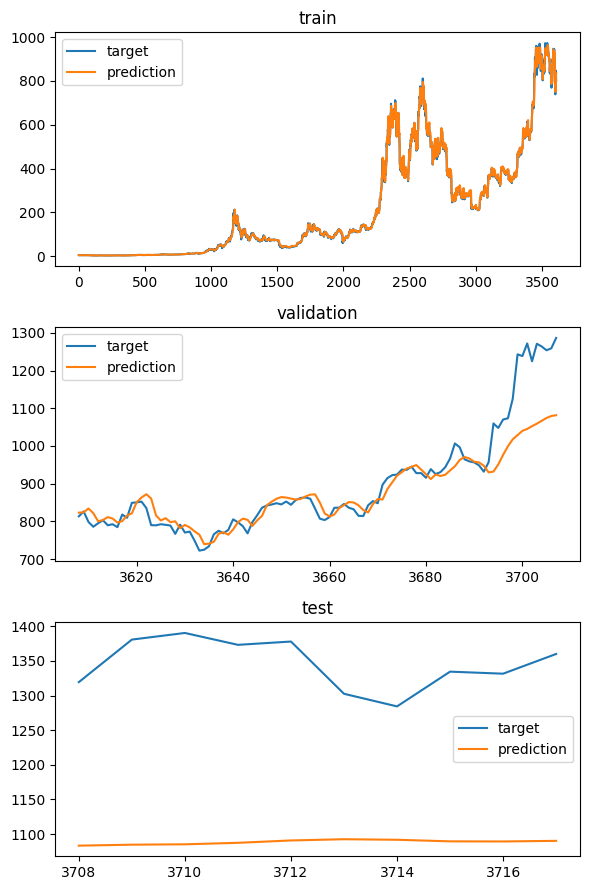

In [2]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path

BASE_PATH = str(Path(os.getcwd()).resolve())
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)

from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._03_real_world_data_to_tensors.p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
  CryptoCurrencyDataset
from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_model, get_btc_krw_data


def test(test_model):
  _, _, test_data_loader = get_btc_krw_data()

  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))


def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=10, validation_size=100, test_size=10,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  project_name = "lstm_regression_btc_krw"
  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)


if __name__ == "__main__":
  parser = get_parser()
  args, unknown = parser.parse_known_args()
  args.wandb = True
  main(args)


_01_code/_15_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py

In [3]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path

BASE_PATH = str(Path(os.getcwd()).resolve())
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)

from _01_code._08_fcn_best_practice.c_trainer import ClassificationTrainer
from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_btc_krw_data

def get_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=3, batch_first=True)
            self.fcn = nn.Linear(in_features=256, out_features=n_output)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:, -1, :]
            x = self.fcn(x)
            return x

    my_model = MyModel(n_input=5, n_output=2)
    return my_model

def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'weight_decay': args.weight_decay
    }

    project_name = "lstm_classification_btc_krw"
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "classification", "btc_krw"],
        name=run_time_str,
        config=config
    )
    print(args)
    print(dict(wandb.config))

    wandb.config.update(config, allow_val_change=True)

    train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    model = get_model()
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=wandb.config['learning_rate'], weight_decay=wandb.config['weight_decay'])

    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    classification_trainer.train_loop()

    wandb.finish()

if __name__ == "__main__":
    parser = get_parser()
    args, unknown = parser.parse_known_args()
    args.wandb = True
    main(args)
    # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69181, T_accuracy: 52.7993 | V_loss: 0.68918, V_accuracy: 56.0000 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69076, T_accuracy: 53.1874 | V_loss: 0.69837, V_accuracy: 44.0000 | Early stopping counter: 1 out of 30 | T_time: 00:00:02, T_speed: 15.000
[Epoch  60] T_loss: 0.69046, T_accuracy: 53.0211 | V_loss: 0.69792, V_accuracy: 44.0000 | Early stopping counter: 2 out of 30 | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.69060, T_accuracy: 53.0765 | V_loss: 0.69741, V_accuracy: 44.0000 | Early stopping counter: 3 out of 30 | T_time: 00:00:05, T_speed: 18.000
[Epoch 120] T_loss: 0.690

_01_code/_15_lstm_and_its_application/j_crypto_currency_classification_test_lstm.py

In [4]:
import torch
import os
from pathlib import Path
from datetime import datetime
import wandb

BASE_PATH = str(Path(os.getcwd()).resolve())
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)

from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_btc_krw_data
from _01_code._15_lstm_and_its_application.i_crypto_currency_classification_train_lstm import get_model


def test(test_model):
  _, _, test_data_loader = get_btc_krw_data(is_regression=False)

  test_model.eval()

  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

      predicted_test = torch.argmax(output_test, dim=1)
      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)


if __name__ == "__main__":
  parser = get_parser()
  args, unknown = parser.parse_known_args()
  args.wandb = True
  main(args)


MODEL FILE: /home/work/DL/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 70.000%
 0:   0.00 <-->   1.00
 1:   0.00 <-->   0.00
 2:   0.00 <-->   1.00
 3:   0.00 <-->   0.00
 4:   0.00 <-->   0.00
 5:   1.00 <-->   1.00
 6:   0.00 <-->   1.00
 7:   0.00 <-->   0.00
 8:   1.00 <-->   1.00
 9:   1.00 <-->   1.00


---

# [문제 2] 적절한 새로운 모델 구성 및 하이퍼파라미터 찾기

Regression

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path

BASE_PATH = str(Path(os.getcwd()).resolve())
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)

from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._14_rnn.g_rnn_trainer import RegressionTrainer
from _01_code._03_real_world_data_to_tensors.p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
  CryptoCurrencyDataset

def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True):
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date = get_cryptocurrency_data(
        sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
        target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
    )

    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    train_data_loader = DataLoader(dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True)
    validation_data_loader = DataLoader(dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True)
    test_data_loader = DataLoader(dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True)

    return train_data_loader, validation_data_loader, test_data_loader

def get_model(n_input, n_output, n_lstm_layers, n_linear_layers, dropout_rate):
    class MyModel(nn.Module):
        def __init__(self):
            super().__init__()

            self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=n_lstm_layers, batch_first=True, dropout=dropout_rate)
            
            linear_layers = []
            input_size = 128
            for _ in range(n_linear_layers):
                linear_layers.append(nn.Linear(input_size, 256))
                linear_layers.append(nn.ReLU())
                linear_layers.append(nn.Dropout(p=dropout_rate))
                input_size = 256
            linear_layers.append(nn.Linear(input_size, n_output))
            self.linear_layers = nn.Sequential(*linear_layers)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:, -1, :]
            x = self.linear_layers(x)
            return x

    return MyModel()

def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'weight_decay': args.weight_decay,
        'n_lstm_layers': args.n_lstm_layers,
        'n_linear_layers': args.n_linear_layers,
        'dropout_rate': args.dropout_rate
    }

    project_name = "hyperparameter_lstm_regression_btc_krw"
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "regression", "btc_krw"],
        name=run_time_str,
        config=config
    )
    print(args)
    print(dict(wandb.config))

    train_data_loader, validation_data_loader, _ = get_btc_krw_data()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    model = get_model(n_input=5, n_output=1, n_lstm_layers=args.n_lstm_layers, n_linear_layers=args.n_linear_layers, dropout_rate=args.dropout_rate)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

    regression_trainer = RegressionTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    regression_trainer.train_loop()

    wandb.finish()


if __name__ == "__main__":
    parser = get_parser()
    parser.add_argument('--n_lstm_layers', type=int, default=2, help='Number of LSTM layers')
    parser.add_argument('--n_linear_layers', type=int, default=2, help='Number of linear layers')
    parser.add_argument('--dropout_rate', type=float, default=0.3, help='Dropout rate')
    args, unknown = parser.parse_known_args()
    args.wandb = True
    
    args.n_lstm_layers = 2
    args.n_linear_layers = 2
    args.dropout_rate = 0.35
    args.weight_decay = 0.0001
    main(args)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: hwanhee136129 (hwanhee136129-korea-university-of-technology-and-education). Use `wandb login --relogin` to force relogin
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0001, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06, n_lstm_layers=2, n_linear_layers=2, dropout_rate=0.35)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0001, 'n_lstm_layers': 2, 'n_linear_layers': 2, 'dropout_rate': 0.35}
Training on device cuda:0.
[Epoch   1] T_loss: 9.61668, V_loss: 74.34883, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.004
[Epoch  30] T_loss: 4.19805, V_loss: 33.84621, V_loss decreased (74.34883 --> 33.84621). Saving model... | T_time: 00:00:01, T_speed: 0.049
[Epoch  60] T_loss: 0.34994, V_loss: 3.05845, V_loss decreased (33.84621 --> 3.05845). Saving model... | T_time: 00:00:03, T_speed: 0.465
[Epoch  90] T_loss: 0.19004, V_loss: 0.45626, V_loss decreased (3.05845 --> 0.45626). Saving model... | T_time: 00:00:04, T_speed:

[Epoch 1800] T_loss: 0.08048, V_loss: 0.06769, V_loss decreased (0.06909 --> 0.06769). Saving model... | T_time: 00:01:24, T_speed: 4.666
[Epoch 1830] T_loss: 0.08379, V_loss: 0.06914, Early stopping counter: 1 out of 30 | T_time: 00:01:25, T_speed: 2.358
[Epoch 1860] T_loss: 0.08649, V_loss: 0.07027, Early stopping counter: 2 out of 30 | T_time: 00:01:27, T_speed: 13.165
[Epoch 1890] T_loss: 0.08543, V_loss: 0.06728, V_loss decreased (0.06769 --> 0.06728). Saving model... | T_time: 00:01:28, T_speed: 3.910
[Epoch 1920] T_loss: 0.07746, V_loss: 0.06817, Early stopping counter: 1 out of 30 | T_time: 00:01:30, T_speed: 55.746
[Epoch 1950] T_loss: 0.08667, V_loss: 0.07228, Early stopping counter: 2 out of 30 | T_time: 00:01:31, T_speed: 4.414
[Epoch 1980] T_loss: 0.07944, V_loss: 0.06418, V_loss decreased (0.06728 --> 0.06418). Saving model... | T_time: 00:01:32, T_speed: 2.484
[Epoch 2010] T_loss: 0.08823, V_loss: 0.06491, Early stopping counter: 1 out of 30 | T_time: 00:01:34, T_speed: 

[Epoch 3810] T_loss: 0.07266, V_loss: 0.05210, Early stopping counter: 9 out of 30 | T_time: 00:02:57, T_speed: 3.925
[Epoch 3840] T_loss: 0.07049, V_loss: 0.05136, Early stopping counter: 10 out of 30 | T_time: 00:02:59, T_speed: 6.718
[Epoch 3870] T_loss: 0.06772, V_loss: 0.06850, Early stopping counter: 11 out of 30 | T_time: 00:03:01, T_speed: 17.302
[Epoch 3900] T_loss: 0.06575, V_loss: 0.05386, Early stopping counter: 12 out of 30 | T_time: 00:03:02, T_speed: 4.358
[Epoch 3930] T_loss: 0.06213, V_loss: 0.05108, Early stopping counter: 13 out of 30 | T_time: 00:03:04, T_speed: 7.829
[Epoch 3960] T_loss: 0.06543, V_loss: 0.04923, Early stopping counter: 14 out of 30 | T_time: 00:03:06, T_speed: 25.367
[Epoch 3990] T_loss: 0.06849, V_loss: 0.04917, V_loss decreased (0.04918 --> 0.04917). Saving model... | T_time: 00:03:07, T_speed: 5.042
[Epoch 4020] T_loss: 0.06985, V_loss: 0.04873, V_loss decreased (0.04917 --> 0.04873). Saving model... | T_time: 00:03:09, T_speed: 5.684
[Epoch 40

Epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
Training loss,█▅▄▅▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁█▁▃▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▂▁▁▂█▁
Validation loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,5010
Training loss,0.0574
Training speed (epochs/sec.),41.51957
Validation loss,0.05034


LSTM 레이어 수: 2

Linear 레이어 수: 2

DropOut: 0.35

Weight Decay: 0.0001

LSTM 레이어 수 조정:
다양한 LSTM 레이어 수(2, 3, 4)를 테스트했다. 2개의 LSTM 레이어가 가장 좋은 성능을 보였다.

Linear 레이어 수 조정:
Linear 레이어 수를 2, 3으로 조정하여 테스트했으며, 2개의 Linear 레이어가 적합했다.

DropOut 조정:
DropOut 비율을 0.1, 0.35, 0.5로 변경하여 테스트했다. DropOut 비율 0.35가 가장 적합했다.

Weight Decay 조정:
Weight Decay 값을 0.0001, 0.00005, 0.00001로 조정하여 테스트했다. Weight Decay 0.0001이 가장 적합했다.

MODEL FILE: /home/work/DL/checkpoints/hyperparameter_lstm_regression_btc_krw_checkpoint_2024-12-20_10-00-28.pt
[TEST DATA]
 0:  -2.63 <--> 1,360.09 (Loss:      1,362.72)
 1:  -2.05 <--> 1,390.43 (Loss:      1,392.49)
 2:  -2.04 <--> 1,380.87 (Loss:      1,382.91)
 3:  -2.90 <--> 1,284.38 (Loss:      1,287.29)
 4:  -2.49 <--> 1,334.58 (Loss:      1,337.07)
 5:  -2.02 <--> 1,319.45 (Loss:      1,321.47)
 6:  -2.96 <--> 1,378.05 (Loss:      1,381.01)
 7:  -3.15 <--> 1,302.60 (Loss:      1,305.75)
 8:  -2.48 <--> 1,373.29 (Loss:      1,375.78)
 9:  -2.48 <--> 1,331.62 (Loss:      1,334.10)


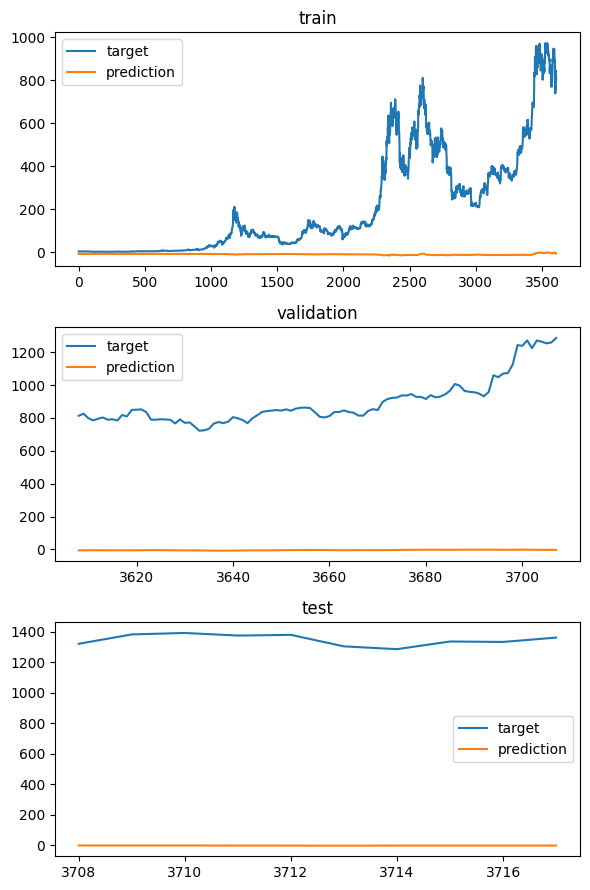

In [3]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path

BASE_PATH = str(Path(os.getcwd()).resolve())
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)

from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._03_real_world_data_to_tensors.p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
  CryptoCurrencyDataset
from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_model, get_btc_krw_data


def test(test_model):
  _, _, test_data_loader = get_btc_krw_data()

  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))


def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=10, validation_size=100, test_size=10,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "hyperparameter_lstm_regression_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="hyperparameter_lstm_regression_btc_krw",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  project_name = "hyperparameter_lstm_regression_btc_krw"
  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"hyperparameter_lstm_regression_btc_krw_checkpoint_2024-12-20_10-00-28.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')), strict=False)

  test(test_model)
  predict_all(test_model)


if __name__ == "__main__":
  parser = get_parser()
  args, unknown = parser.parse_known_args()
  args.wandb = True
  main(args)


classification

In [1]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path

BASE_PATH = str(Path(os.getcwd()).resolve())
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)

from _01_code._08_fcn_best_practice.c_trainer import ClassificationTrainer
from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_btc_krw_data

def get_model(n_input=5, n_output=2, n_lstm_layers=3, n_linear_layers=1, dropout_rate=0.0):
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output, n_lstm_layers, n_linear_layers, dropout_rate):
            super().__init__()

            self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=n_lstm_layers, batch_first=True)
            self.fc_layers = []
            for _ in range(n_linear_layers):
                self.fc_layers.append(nn.Linear(256, 256))
                self.fc_layers.append(nn.ReLU())
                if dropout_rate > 0:
                    self.fc_layers.append(nn.Dropout(dropout_rate))
            self.fc_layers.append(nn.Linear(256, n_output))
            self.fc_layers = nn.Sequential(*self.fc_layers)

        def forward(self, x):
            x, _ = self.lstm(x)
            x = x[:, -1, :] 
            x = self.fc_layers(x)
            return x

    return MyModel(n_input, n_output, n_lstm_layers, n_linear_layers, dropout_rate)

def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'weight_decay': args.weight_decay
    }

    project_name = "hyperparameter_lstm_classification_btc_krw"
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "classification", "btc_krw"],
        name=run_time_str,
        config=config
    )
    print(args)
    print(dict(wandb.config))

    wandb.config.update(config, allow_val_change=True)

    train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    model = get_model(n_input=5, n_output=2, n_lstm_layers=3, n_linear_layers=1, dropout_rate=0.0)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=wandb.config['learning_rate'], weight_decay=wandb.config['weight_decay'])

    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    classification_trainer.train_loop()

    wandb.finish()

if __name__ == "__main__":
    parser = get_parser()
    parser.add_argument('--n_lstm_layers', type=int, default=3, help='Number of LSTM layers')
    parser.add_argument('--n_linear_layers', type=int, default=1, help='Number of linear layers')
    parser.add_argument('--dropout_rate', type=float, default=0.0, help='Dropout rate')
    args, unknown = parser.parse_known_args()
    args.wandb = True

    args.n_lstm_layers = 4
    args.n_linear_layers = 3
    args.dropout_rate = 0.0
    args.weight_decay = 0.0

    main(args)

    # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: hwanhee136129 (hwanhee136129-korea-university-of-technology-and-education). Use `wandb login --relogin` to force relogin
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06, n_lstm_layers=4, n_linear_layers=3, dropout_rate=0.0)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69399, T_accuracy: 47.2007 | V_loss: 0.69404, V_accuracy: 44.0000 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69077, T_accuracy: 53.0211 | V_loss: 0.69879, V_accuracy: 44.0000 | Early stopping counter: 1 out of 30 | T_time: 00:00:02, T_speed: 15.000
[Epoch  60] T_loss: 0.69052, T_accuracy: 52.9933 | V_loss: 0.69723, V_accuracy: 44.0000 | Early stopping counter: 2 out of 30 | T_time: 00:00:04, T_speed: 15.000
[Epoch  90] T_loss: 0.69045, T_accuracy: 53.2151 | V_loss: 0.69836, V_accuracy: 44.0000 | Early stopping counter

[Epoch 1440] T_loss: 0.51888, T_accuracy: 67.4058 | V_loss: 3.03412, V_accuracy: 55.0000 | Early stopping counter: 29 out of 30 | T_time: 00:01:57, T_speed: 12.308
[Epoch 1470] T_loss: 0.51379, T_accuracy: 67.6829 | V_loss: 3.12073, V_accuracy: 55.0000 | Early stopping counter: 30 out of 30 *** TRAIN EARLY STOPPED! *** | T_time: 00:02:00, T_speed: 12.250
Final training time: 00:02:00


Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Training accuracy (%),▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
Training loss,████████████████████▇▇▇▇▆▅▅▅▅▅▄▄▃▃▃▂▂▂▁▁
Training speed (epochs/sec.),▁████▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Validation accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▃▇▆█▆██▇▇▇█▆▄▆▅▄▃▆▆▅▆▄▇▆▅▆▆▆
Validation loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▄▄▅▅▅▆▆▇▆▆▇▇█
Epoch,1470
Training accuracy (%),67.68293
Training loss,0.51379
Training speed (epochs/sec.),12.25
Validation accuracy (%),55


In [ ]:
Classification Model 하이퍼파라미터 값
LSTM 레이어 수: 4

Linear 레이어 수: 3

DropOu: 0.0

Weight Decay: 0.0

LSTM 레이어 수 조정:
다양한 LSTM 레이어 수(2, 3, 4, 5)를 테스트하했다. 4개의 LSTM 레이어가 적합했다.

Linear 레이어 수 조정:
Linear 레이어 수를 2, 3, 4로 조정하여 테스트했으며, 3개의 Linear 레이어가 적합했다.

DropOut 조정:
DropOut 비율을 0.0, 0.2, 0.3, 0.5로 변경하여 테스트했다. DropOut을 사용하지 않는 것이 좋았다.

Weight Decay 조정:
Weight Decay 값을 0.0, 0.0001, 0.0005로 조정하여 테스트했다. Weifgt Decay를 사용하지 않는 것이 좋았다.

In [10]:
import torch
import os
from pathlib import Path
from datetime import datetime
import wandb

BASE_PATH = str(Path(os.getcwd()).resolve())
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)

from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_btc_krw_data
from _01_code._15_lstm_and_its_application.i_crypto_currency_classification_train_lstm import get_model


def test(test_model):
  _, _, test_data_loader = get_btc_krw_data(is_regression=False)

  test_model.eval()

  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

      predicted_test = torch.argmax(output_test, dim=1)
      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "hyperparameter_lstm_classification_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')), strict=False)

  test(test_model)


if __name__ == "__main__":
  parser = get_parser()
  args, unknown = parser.parse_known_args()
  args.wandb = True
  main(args)


MODEL FILE: /home/work/DL/checkpoints/hyperparameter_lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 60.000%
 0:   1.00 <-->   0.00
 1:   1.00 <-->   0.00
 2:   1.00 <-->   1.00
 3:   1.00 <-->   1.00
 4:   1.00 <-->   0.00
 5:   1.00 <-->   1.00
 6:   1.00 <-->   1.00
 7:   1.00 <-->   1.00
 8:   1.00 <-->   1.00
 9:   1.00 <-->   0.00


---

[문제 3] 데이터 Feature 추가 후 성능 변화 확인하기

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path
import pandas as pd

BASE_PATH = str(Path(os.getcwd()).resolve())
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)

from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._14_rnn.g_rnn_trainer import RegressionTrainer
from _01_code._03_real_world_data_to_tensors.p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
  CryptoCurrencyDataset

def add_next_open_column(data):
    data['Next_Open'] = data['Open'].shift(-1)
    data = data[:-1]
    return data

def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True):
    data = pd.read_csv('BTC_KRW.csv')
    data = add_next_open_column(data)
    
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date = get_cryptocurrency_data(
        sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
        target_column='Next_Open', y_normalizer=1.0e7, is_regression=is_regression
    )

    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    train_data_loader = DataLoader(dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True)
    validation_data_loader = DataLoader(dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True)
    test_data_loader = DataLoader(dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True)

    return train_data_loader, validation_data_loader, test_data_loader

def get_model(n_input, n_output, n_lstm_layers, n_linear_layers, dropout_rate):
    class MyModel(nn.Module):
        def __init__(self):
            super().__init__()

            self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=n_lstm_layers, batch_first=True, dropout=dropout_rate)
            
            linear_layers = []
            input_size = 128
            for _ in range(n_linear_layers):
                linear_layers.append(nn.Linear(input_size, 256))
                linear_layers.append(nn.ReLU())
                linear_layers.append(nn.Dropout(p=dropout_rate))
                input_size = 256
            linear_layers.append(nn.Linear(input_size, n_output))
            self.linear_layers = nn.Sequential(*linear_layers)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:, -1, :]
            x = self.linear_layers(x)
            return x

    return MyModel()

def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'weight_decay': args.weight_decay,
        'n_lstm_layers': args.n_lstm_layers,
        'n_linear_layers': args.n_linear_layers,
        'dropout_rate': args.dropout_rate
    }

    project_name = "NextOpen_lstm_regression_btc_krw"
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "regression", "btc_krw"],
        name=run_time_str,
        config=config
    )
    print(args)
    print(dict(wandb.config))

    train_data_loader, validation_data_loader, _ = get_btc_krw_data()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    model = get_model(n_input=6, n_output=1, n_lstm_layers=args.n_lstm_layers, n_linear_layers=args.n_linear_layers, dropout_rate=args.dropout_rate)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

    regression_trainer = RegressionTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    regression_trainer.train_loop()

    wandb.finish()

if __name__ == "__main__":
    parser = get_parser()
    parser.add_argument('--n_lstm_layers', type=int, default=2, help='Number of LSTM layers')
    parser.add_argument('--n_linear_layers', type=int, default=2, help='Number of linear layers')
    parser.add_argument('--dropout_rate', type=float, default=0.3, help='Dropout rate')
    args, unknown = parser.parse_known_args()
    args.wandb = True
    
    args.n_lstm_layers = 2
    args.n_linear_layers = 2
    args.dropout_rate = 0.35
    args.weight_decay = 0.0001
    main(args)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: hwanhee136129 (hwanhee136129-korea-university-of-technology-and-education). Use `wandb login --relogin` to force relogin
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0001, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06, n_lstm_layers=2, n_linear_layers=2, dropout_rate=0.35)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0001, 'n_lstm_layers': 2, 'n_linear_layers': 2, 'dropout_rate': 0.35}
Training on device cuda:0.
[Epoch   1] T_loss: 9.36738, V_loss: 72.90107, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.003
[Epoch  30] T_loss: 2.47993, V_loss: 21.77336, V_loss decreased (72.90107 --> 21.77336). Saving model... | T_time: 00:00:01, T_speed: 0.034
[Epoch  60] T_loss: 0.32328, V_loss: 2.84105, V_loss decreased (21.77336 --> 2.84105). Saving model... | T_time: 00:00:03, T_speed: 0.109
[Epoch  90] T_loss: 0.18287, V_loss: 0.34678, V_loss decreased (2.84105 --> 0.34678). Saving model... | T_time: 00:00:05, T_speed:

[Epoch 1830] T_loss: 0.07535, V_loss: 0.07600, Early stopping counter: 2 out of 30 | T_time: 00:01:42, T_speed: 2.979
[Epoch 1860] T_loss: 0.07532, V_loss: 0.06853, Early stopping counter: 3 out of 30 | T_time: 00:01:44, T_speed: 8.707
[Epoch 1890] T_loss: 0.07559, V_loss: 0.06143, V_loss decreased (0.06394 --> 0.06143). Saving model... | T_time: 00:01:45, T_speed: 2.300
[Epoch 1920] T_loss: 0.07813, V_loss: 0.06089, V_loss decreased (0.06143 --> 0.06089). Saving model... | T_time: 00:01:47, T_speed: 3.810
[Epoch 1950] T_loss: 0.08105, V_loss: 0.06789, Early stopping counter: 1 out of 30 | T_time: 00:01:49, T_speed: 10.007
[Epoch 1980] T_loss: 0.07362, V_loss: 0.06185, Early stopping counter: 2 out of 30 | T_time: 00:01:50, T_speed: 2.300
[Epoch 2010] T_loss: 0.07542, V_loss: 0.06433, Early stopping counter: 3 out of 30 | T_time: 00:01:52, T_speed: 2.849
[Epoch 2040] T_loss: 0.07512, V_loss: 0.06118, Early stopping counter: 4 out of 30 | T_time: 00:01:54, T_speed: 5.577
[Epoch 2070] T_

[Epoch 3870] T_loss: 0.06480, V_loss: 0.05696, Early stopping counter: 9 out of 30 | T_time: 00:03:36, T_speed: 6.240
[Epoch 3900] T_loss: 0.06636, V_loss: 0.05517, Early stopping counter: 10 out of 30 | T_time: 00:03:38, T_speed: 17.090
[Epoch 3930] T_loss: 0.06564, V_loss: 0.05981, Early stopping counter: 11 out of 30 | T_time: 00:03:39, T_speed: 4.724
[Epoch 3960] T_loss: 0.06049, V_loss: 0.06502, Early stopping counter: 12 out of 30 | T_time: 00:03:41, T_speed: 6.997
[Epoch 3990] T_loss: 0.06126, V_loss: 0.05577, Early stopping counter: 13 out of 30 | T_time: 00:03:43, T_speed: 45.884
[Epoch 4020] T_loss: 0.06149, V_loss: 0.05549, Early stopping counter: 14 out of 30 | T_time: 00:03:44, T_speed: 6.710
[Epoch 4050] T_loss: 0.06421, V_loss: 0.08687, Early stopping counter: 15 out of 30 | T_time: 00:03:46, T_speed: 23.958
[Epoch 4080] T_loss: 0.05697, V_loss: 0.05159, Early stopping counter: 16 out of 30 | T_time: 00:03:47, T_speed: 4.985
[Epoch 4110] T_loss: 0.06026, V_loss: 0.05025,

Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇█
Training loss,█▇▇▇▆▆▅▅▄▅▄▄▄▄▃▃▃▄▃▂▃▃▃▂▂▃▂▂▂▂▂▂▂▂▁▁▂▁▁▂
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂█▁▁▁▁▁▁▁▂▁▁▃▁▃▁▄
Validation loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,5190
Training loss,0.05985
Training speed (epochs/sec.),9.86533
Validation loss,0.05737


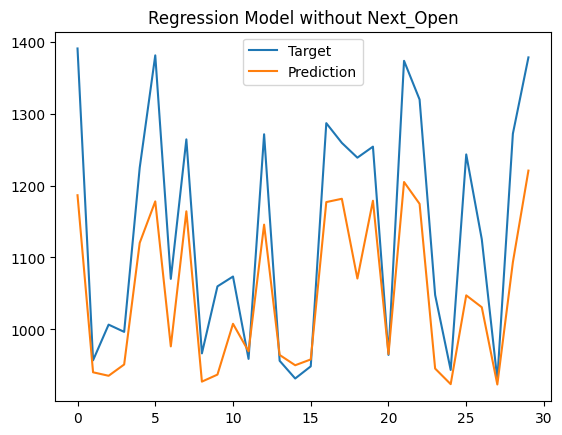

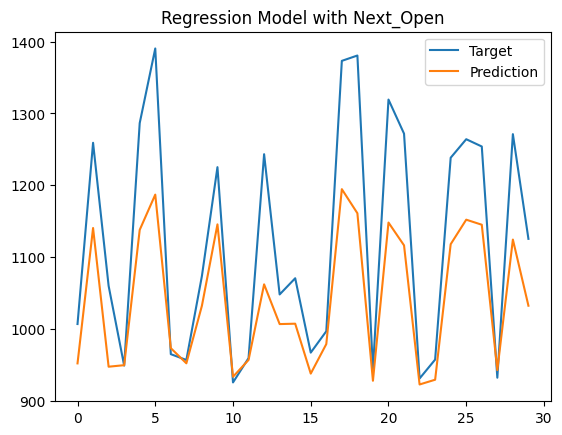

In [4]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import pandas as pd

# Add Next_Open column
def add_next_open_column(data):
    data['Next_Open'] = data['Open'].shift(-1)
    data = data[:-1]
    return data

# 수정된 get_cryptocurrency_data 함수
def get_cryptocurrency_data(
    df, sequence_size=10, validation_size=100, test_size=10, target_column='Close', y_normalizer=1.0e7, is_regression=True
):
    row_size = len(df)
    date_list = df['Date']
    df = df.drop(columns=['Date'])
    data_size = row_size - sequence_size
    train_size = data_size - (validation_size + test_size)

    row_cursor = 0

    X_train_list = []
    y_train_regression_list = []
    y_train_classification_list = []
    y_train_date = []
    for idx in range(0, train_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values
        X_train_list.append(torch.from_numpy(sequence_data))
        y_train_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_train_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_train_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_train = torch.stack(X_train_list, dim=0).to(torch.float)
    y_train_regression = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalizer
    y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)

    m = X_train.mean(dim=0, keepdim=True)
    s = X_train.std(dim=0, keepdim=True)
    X_train = (X_train - m) / s

    X_validation_list = []
    y_validation_regression_list = []
    y_validation_classification_list = []
    y_validation_date = []
    for idx in range(row_cursor, row_cursor + validation_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values
        X_validation_list.append(torch.from_numpy(sequence_data))
        y_validation_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_validation_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_validation_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_validation = torch.stack(X_validation_list, dim=0).to(torch.float)
    y_validation_regression = torch.tensor(y_validation_regression_list, dtype=torch.float32) / y_normalizer
    y_validation_classification = torch.tensor(y_validation_classification_list, dtype=torch.int64)

    X_validation = (X_validation - m) / s

    X_test_list = []
    y_test_regression_list = []
    y_test_classification_list = []
    y_test_date = []
    for idx in range(row_cursor, row_cursor + test_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values
        X_test_list.append(torch.from_numpy(sequence_data))
        y_test_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_test_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] > df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_test_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_test = torch.stack(X_test_list, dim=0).to(torch.float)
    y_test_regression = torch.tensor(y_test_regression_list, dtype=torch.float32) / y_normalizer
    y_test_classification = torch.tensor(y_test_classification_list, dtype=torch.int64)

    X_test = (X_test - m) / s

    if is_regression:
        return (
            X_train, X_validation, X_test,
            y_train_regression, y_validation_regression, y_test_regression,
            y_train_date, y_validation_date, y_test_date
        )
    else:
        return (
            X_train, X_validation, X_test,
            y_train_classification, y_validation_classification, y_test_classification,
            y_train_date, y_validation_date, y_test_date
        )

# Load BTC/KRW data
def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, include_next_open=False):
    data = pd.read_csv('BTC_KRW.csv')
    if include_next_open:
        data = add_next_open_column(data)
        data = data.reset_index(drop=True)
        target_column = 'Next_Open'
    else:
        target_column = 'Close'
    
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date = get_cryptocurrency_data(
        df=data, sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
        target_column=target_column, y_normalizer=1.0e7, is_regression=True
    )

    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    train_data_loader = DataLoader(dataset=train_crypto_currency_dataset, batch_size=64, shuffle=True)
    validation_data_loader = DataLoader(dataset=validation_crypto_currency_dataset, batch_size=64, shuffle=True)
    test_data_loader = DataLoader(dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True)

    return train_data_loader, validation_data_loader, test_data_loader

# Model definition
def get_model(n_input, n_output, n_lstm_layers, n_linear_layers, dropout_rate):
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output, n_lstm_layers, n_linear_layers, dropout_rate):
            super().__init__()
            self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=n_lstm_layers, batch_first=True, dropout=dropout_rate)
            
            linear_layers = []
            input_size = 128
            for _ in range(n_linear_layers):
                linear_layers.append(nn.Linear(input_size, 256))
                linear_layers.append(nn.ReLU())
                linear_layers.append(nn.Dropout(p=dropout_rate))
                input_size = 256
            linear_layers.append(nn.Linear(input_size, n_output))
            self.linear_layers = nn.Sequential(*linear_layers)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:, -1, :]
            x = self.linear_layers(x)
            return x
    return MyModel(n_input, n_output, n_lstm_layers, n_linear_layers, dropout_rate)

# Evaluate test performance and plot results
def test_and_plot(model_path, include_next_open, sequence_size=21):
    n_input = 6 if include_next_open else 5
    model = get_model(n_input=n_input, n_output=1, n_lstm_layers=2, n_linear_layers=2, dropout_rate=0.3)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')), strict=False)
    
    model.eval()
    
    y_normalizer = 100
    
    _, _, test_data_loader = get_btc_krw_data(sequence_size=sequence_size, include_next_open=include_next_open)
    
    X, TARGET_Y, PREDICTION_Y = [], [], []
    with torch.no_grad():
        for test_batch in test_data_loader:
            input_test, target_test = test_batch
            if not include_next_open:
                input_test = input_test[..., :-1]
            
            output_test = model(input_test)
            
            for idx, (output, target) in enumerate(zip(output_test, target_test)):
                X.append(idx)
                TARGET_Y.append(target.item() * y_normalizer)
                PREDICTION_Y.append(output.item() * y_normalizer)
    
    plt.figure()
    plt.plot(X, TARGET_Y, label='Target')
    plt.plot(X, PREDICTION_Y, label='Prediction')
    plt.title(f"Regression Model {'with' if include_next_open else 'without'} Next_Open")
    plt.legend()
    plt.show()

def main():
    base_model_path = "hyperparameter_lstm_regression_btc_krw_checkpoint_2024-12-20_10-00-28.pt"
    next_open_model_path = "NextOpen_lstm_regression_btc_krw_checkpoint_latest.pt"
    
    test_and_plot(base_model_path, include_next_open=False)
    test_and_plot(next_open_model_path, include_next_open=True)

if __name__ == "__main__":
    main()


Next_Open 피처를 추가함으로써 회귀 모델의 성능이 비교적 향상되었다. Target 값과 Prediction 값의 차이가 줄어들었고, 모델의 예측 성능이 전반적으로 개선되었다. 이러한 결과는 데이터 피처의 중요성을 강조하며, 적절한 피처 추가가 모델 성능을 향상시킬 수 있음을 보여준다.

# 숙제후기

이번 과제를 통해 딥러닝 모델을 학습시키는 전 과정을 직접 경험하면서 많은 것을 배울 수 있었습니다. 암호화폐 데이터를 활용하여 모델 학습을 진행하면서, 데이터의 전처리가 모델 성능에 큰 영향을 미친다는 것을 느낄 수 있었습니다. 특히, 다양한 하이퍼파라미터 설정을 실험하며 최적의 모델 구성을 찾는 과정에서 많은 인사이트를 얻었습니다.

LSTM 모델을 활용하여 회귀 및 분류 문제를 해결하면서, 학습 속도와 성능 모두에서 뛰어난 결과를 얻을 수 있었습니다. 학습 후 테스트 데이터에 대해 예측을 진행하고 결과를 분석하면서, 모델의 성능을 평가할 수 있었습니다. 이를 통해 모델을 더 잘 이해하는 데 큰 도움이 되었습니다.

데이터 피처에 Next_Open을 추가하여 학습 성능의 변화를 확인하는 과정에서도 다양한 시도를 통해 모델 성능을 개선하는 방법을 배웠습니다. 다만, 문제 3번에서 Next_Open 피처를 추가한 후 성능 변화를 확인하는 과정에서 예상하지 못한 어려움이 발생하여 아쉬움이 남았습니다. 이를 해결하지 못한 점이 조금 아쉽지만, 이러한 실패도 많은 학습과 성장을 가져다 준다는 점에서 유익한 경험이었습니다.

이번 학기 딥러닝 및 실습 과목을 통해 딥러닝 모델 학습의 전체적인 흐름을 보다 잘 이해할 수 있었고, 다양한 실험을 통해 모델 성능을 개선하는 방법을 배우게 되어 매우 유익한 경험이었습니다.